<p> Run a simulation of filling in a network based on the 7 de Septiembre neighborhood layout in Araijan </p>
<p>**(.inp and .config files already written)**</p>
<p> Below you see how to:</p>
<ul>
<li>Set boundary and initial conditions </li>
<li>Run a simulation until time T= 1200 s</li>
<li>plot time series of pressure head at different points in a single pipe</li>
<li>plot time series of pressure head at sample points in various pipes</li>
<li>plot space dependence of pressure head at a certain time</li>
<li>look at velocities</li>
<li>plot network layout</li>
</ul>

In [1]:
from __future__ import division
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
#specify input files
fi = "../indata/Xindata/SymmetricY-2.0.inp"    
fc = "../indata/Xindata/SymmetricY-2.0.config" 
mtype = 1                             #model type. set =0 for uniform cross-section channel flow (has not been tested for awhile)
#create a network, n1 denotes the name of the network. It is like reading the file
n1 = PyNetwork(fi,fc,mtype)

In [3]:
#create time series Q(x=0, t) = q0 for t<T/2, 0 for t>=T/2
q0 = 1 #inflow boundary value (m^3/s), used to create the Q0 vector
M = n1.M   #number of time steps
print M
T = n1.T   #simulation length (in seconds)
Q0 = q0*np.ones(M+1)    #This is the actual inflow,q is only used to create Q0 vector        

#boundary condition for junction 0 (at the left end of pipe 0)
n1.setbVal(0,Q0)
p1 = PyPipe_ps(n1.Ns[0], n1.Ds[0],n1.Ls[0], M, n1.a[0]) 
A00 = 0*np.ones(n1.Ns[0])
Q00 = 0*np.ones(n1.Ns[0])
for i in xrange(3):
    n1.setIC(i,A00,Q00)
'''
h0 = p1.AofH(1.5,False)                         # Area when H=10m
A00 = h0*np.ones(n1.Ns[0])                  # n1.Ns[0]-number of grids in pipe 0. So all the grids in pipe 0 have the same area h0
Q00 = Q0[0]*np.ones(n1.Ns[0])
n1.setIC(0,A00,Q00)                       # set the IC of pipe 0
'''
print 'the velocity is',q0/(n1.Ds[0]**2*pi/4),'m/s'
print (n1.Ds[0]**2*pi/4)*500

10000
the velocity is 5.09295817894 m/s
98.1747704247


In [4]:
'''
A0 = np.zeros(M+1)
n1.setbVal(0,A0)
n1.setbVal(1,A0)
n1.setbVal(2,A0)
'''

'\nA0 = np.zeros(M+1)\nn1.setbVal(0,A0)\nn1.setbVal(1,A0)\nn1.setbVal(2,A0)\n'

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


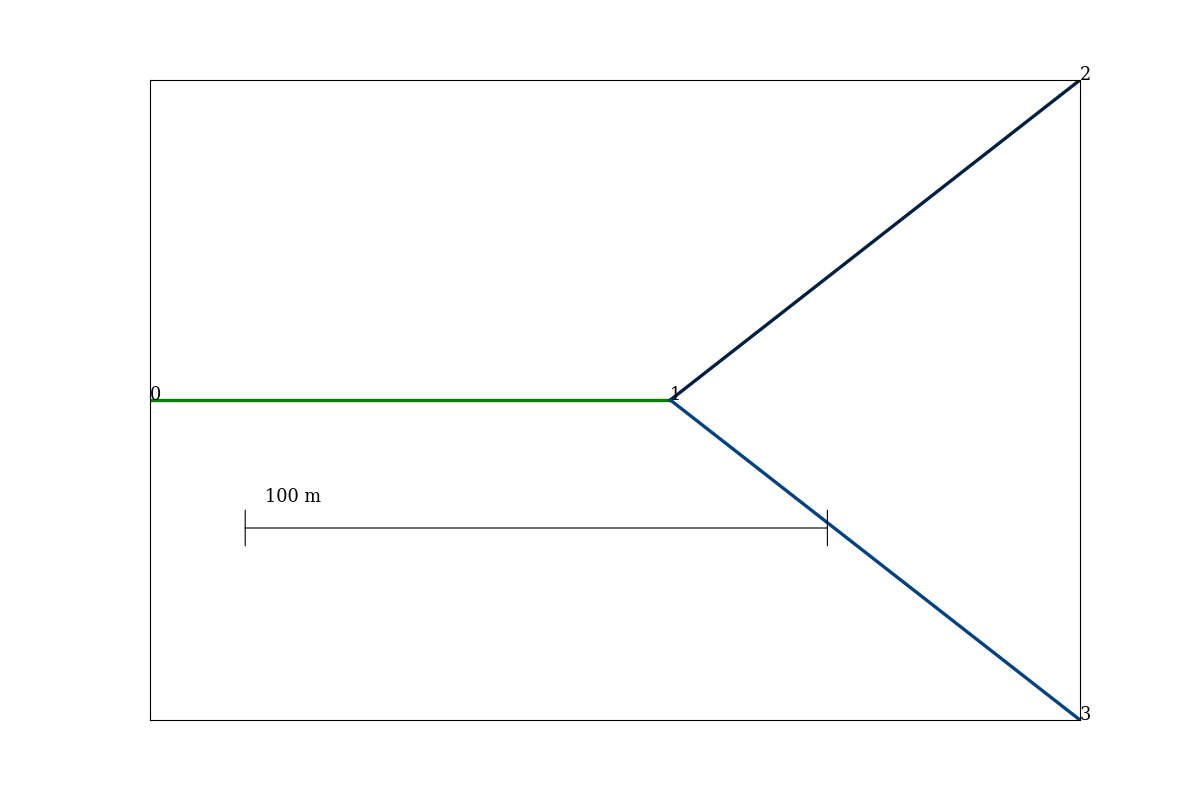

   pipe | start node | end node
-----------------------------------
     0  |  0         | 1
     1  |  1         | 2
     2  |  1         | 3


   node | #incoming pipes
-------------------------
  0     |  1
  1     |  3
  2     |  1
  3     |  1


In [5]:
# uncomment line below to take a look at initial conditions before starting simulation
#n1.showCurrentData()
#plotNetworkLayout (xs, ys, conns, ls, Np)    # must combine with code lines below
#plotNetworkLayout(xs,ys,conns,ls,Np)
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np= shape(conns) [0]
%pylab notebook
plotNetworkLayout (xs, ys, conns, ls, Np) 
n1.showLayout()

In [6]:
#Run the simulation!
print M
dt = T/float(M)#time step
V0 = n1.getTotalVolume()
n1.runForwardProblem(dt)
print 'finished'

10000
finished


In [ ]:
m32gal = 264.172   #conversion factor, m^3 to gallons
m2psi = 1.42       #conversion factor, m of pressure head to psi
mdx = min([n1.Ls[i]/n1.Ns[i] for i in range(n1.Nedges)])
#print timing information
print "Simulated time T = %f s" %n1.T
print "Solve time = %f  s" %n1.solve_time
print "dt = %f" %dt
print "inflow volume = %.2f gallons" % ((n1.getTotalVolume()-V0)*m32gal)
print "pressure wave speed is %f m/s"% (max(n1.a))
print "CFL = 1/(dx/dt)*(max wave speed) = %f" % (max(n1.cmax)*dt/mdx)

In [ ]:
# i = 0 means A, i=1 means Q
# j means grid number [0,N+1] including two grid cells
# n means time step
# N means grid number of this pipe
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)
H1 = n1.pressureSpaceSeries(0,int(M))  
H2 = n1.pressureSpaceSeries(1,int(M)) 
H3 = n1.pressureSpaceSeries(2,int(M)) 
print len(H1) # so H0 only contains real grid values
print H1[-1],H2[0],H3[0]

# print the pressure head at the junction
#print '0:',p1.pbar(0.151917,True),"1,2:",p1.pbar(0.162652,False)

# get pipe (A,Q)data
qh1 = n1.qhist(0)
qh2 = n1.qhist(1)
qh3 = n1.qhist(2)
N = n1.Ns[1]

# For pipe 1, print Qin,Ain,Qext, Aext (right end)
M = n1.M/2
Ain1 = qh1[idx_t(0,N,int(M),N)]
Aext1 = qh1[idx_t(0,N+1,int(M),N)]
Qin1 = qh1[idx_t(1,N,int(M),N)]
Qext1= qh1[idx_t(1,N+1,int(M),N)]
print "The cell value of pipe 1:",Ain1,Qin1,Aext1,Qext1,p1.Eta(Ain1,False)/9.81/Ain1

# For pipe 2, print Qin,Ain,Qext, Aext (left end)
Ain2 = qh2[idx_t(0,1,int(M),N)]
Aext2 = qh2[idx_t(0,0,int(M),N)]
Qin2 = qh2[idx_t(1,1,int(M),N)]
Qext2= qh2[idx_t(1,0,int(M),N)]
print "The cell value of pipe 2:",Ain2,Qin2,Aext2,Qext2,p1.Eta(Ain2,False)/9.81/Ain1

# For pipe 3, print Qin,Ain,Qext, Aext (left end)
Ain3 = qh3[idx_t(0,1,int(M),N)]
Aext3 = qh3[idx_t(0,0,int(M),N)]
Qin3 = qh3[idx_t(1,1,int(M),N)]
Qext3= qh3[idx_t(1,0,int(M),N)]
print "The cell value of pipe 3:",Ain3,Qin3,Aext3,Qext3,p1.Eta(Ain3,False)/9.81/Ain1

print len(qh1)



<IPython.core.display.Javascript object>


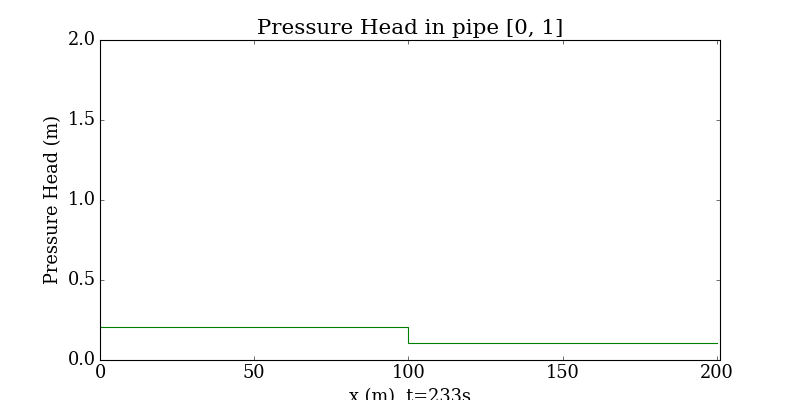

In [7]:
from matplotlib import animation
#*********************************************************************************
pipe_interest=[0,1]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=800               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)

#create initial figure
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(0, 2)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]

def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=30, blit=False)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/T_junction_detection/conti-pipe %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))

In [ ]:
# Display the inflow and outflow for each pipe (m^3)  (ALl PIPES IN MODEL)

def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

# Get Q of two ends of each pipe
Q = []
Mstep=1
#pipe_interest=[0]
pipe_interest=range(0,5)   
'''Here I redefine the pipe_interest vector'''

for i in range(len(pipe_interest)):
    Q_pipefix = [] 
    Q_start=[]
    Q_end=[]
    for m in xrange(0,n1.M,Mstep) :
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j)
        Q_start.append(qh[idx_t(1,1,m,N)])   # Q1
        Q_end.append(qh[idx_t(1,N-1,m,N)])     # QN
    Q_pipefix.append(Q_start)
    Q_pipefix.append(Q_end)
    Q.append(Q_pipefix)
xt = np.linspace(0, n1.M*dt, n1.M/Mstep)
endorstart=['start','end']
for i in range(len(pipe_interest)):
    plt.figure(figsize= (10,4))                # same pipe on same figure
    for j in range(0,2):  
        #figsize = (15,5)                        # plot on same figure           
        #plt.figure(figsize= (15,5))             # plot on different figures
        plot(xt,Q[i][j], lw = 1,label = 'pipe %d, %s'%(pipe_interest[i],endorstart[j]))
        #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   #legend will be placed out of box and cannot be shown
        legend()
        xlabel('time (s)')
        ylabel('flux (m^3/s)')
        title('Flux in pipe %d'%pipe_interest[i])

# calculate inflow and outflow, i means pipe number, j means start or end, time means time in vector  
delta_t=Mstep*dt
Q_total=[]
for i in range(len(pipe_interest)):
    Q_total_pipefix=[]
    for j in range(0,2):
        Q_sum=0
        for time in range(len(Q[i][j])):
            Q_sum += Q[i][j][time]*delta_t
        Q_total_pipefix.append(Q_sum)
        print 'Pipe %d during %d s have total flow: %.3f m^3 (%s node)'%(pipe_interest[i],n1.T,Q_sum,endorstart[j])
    V_dif = Q_total_pipefix[0]- Q_total_pipefix[1]
    print V_dif
    Q_total.append(Q_total_pipefix)

In [ ]:
#show time series at a sensor in the middle of each pipe in the network
# import a nice colormap
from matplotlib import cm
import matplotlib.colors as colors
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('hsv') )
fig = figure(figsize= (15,5))
t = linspace(0,T,M+1)
interesting = arange(0,Np) #pipes you are interested in (currently all)
interesting1 = array([0,1,2,4,6])
for i in interesting1: 
    #look at pressure time series in i^th pipe, pbar(A(X*, t)), where X* = L/2 for pipe length L, and t =0, dt, 2*dt,...dt*M
    P1 = n1.pressureTimeSeries(i,n1.Ns[i]/2-1) 
    plot(t,P1,color =scalarMap.to_rgba(i), label = "pipe %d" %i) 
legend(ncol=7, loc = (0,1))
ax = gca()
ax.set_xlabel('t (s)')
#xlabel('t(s)')
#ylabel('H(m)')
ax.set_ylabel('H (m)')

In [ ]:
#show pressure time series at different locations along the length of a single pipe
i = 1  #pipe number you want to look at
fig = figure(figsize= (15,5))
#new color map
xs = np.arange(1,n1.Ns[i]+1,4)           # all the grids, increment is 2
print xs
print len(xs)
cNorm  = colors.Normalize(vmin=0, vmax=xs[-1]+10)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean') )
t = np.linspace(0,n1.T,M+1)
for J in range(0,len(xs),3):
    cval = scalarMap.to_rgba(xs[J])
    dx = n1.Ls[i]/float(n1.Ns[i])
    P2 = n1.pressureTimeSeries(i,J)
    q=plot(t,P2,color =cval,label="x = %.1f"%(dx*xs[J]))
ax = gca()
ax.set_title('Pipe %d'%i)
ax.set_xlabel('t (s)')
ax.set_ylabel(r'$\bar{p}$ (m)')
#legend()
#legend(loc = 'upper left')
#savefig("../sensors_pipe%d.eps"%i, format='eps')

In [ ]:
#show how pressure profile varies in space at the end of the run 
i = 5  # pipe you want to look at
fig = figure(figsize= (10,5))
#m = M  #time slice you want to look at, the simulation only has M steps, so m here refers to the end of the simulation
for m in range(0,n1.M+1,6000):
    Px = n1.pressureSpaceSeries(i,m)
    x = linspace(0,n1.Ls[i],n1.Ns[i])
    plot(x,Px,label = 't=%.2f s'%(dt*m))
    # title('Pipe %d at time %.2f s'%(i,dt*m))
    legend()
    draw()
    xlabel('x')
    ylabel(r'$\bar{p}(m)$')
    fig = figure(figsize= (10,5))


In [ ]:
#plot network layout
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np = shape(conns)[0]
plotNetworkLayout(xs,ys,conns,ls,Np)

In [ ]:
# The following codes are only used to try python functions, the purpose is about learning python
plt.plot([1,2,3,4], [1,4,9,16], 'ro')
plt.axis([0, 6, 0, 20])
plt.show()


In [ ]:
help(gca)

In [ ]:

1*np.ones(2)

In [ ]:
# Continuous Pressure Head Display
from __future__ import division
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time

#*********************************************************************************
pipe_interest=[2,3,9]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=3600               # unit: s
#*********************************************************************************

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(0,n1.Ls[j],n1.Ns[j])
    x_interest.append(x)

#create initial figure
from matplotlib import animation
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 400)
lines = [plt.plot([], [],label='pipe {}'.format(pipe_interest[i]))[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)

def animate(index): 
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        line.set_data(x_interest[i],Hx)
        plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
        #line.set_label('pipe %d t=%.2f s'%(j,(dt*(M_start+index*Mi_draw))))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=10, blit=True)
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/T_junction_detection/pipe %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))